In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 832)
(2867343, 8)
validation
(519557, 832)
(519557, 8)
test
(237229, 832)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

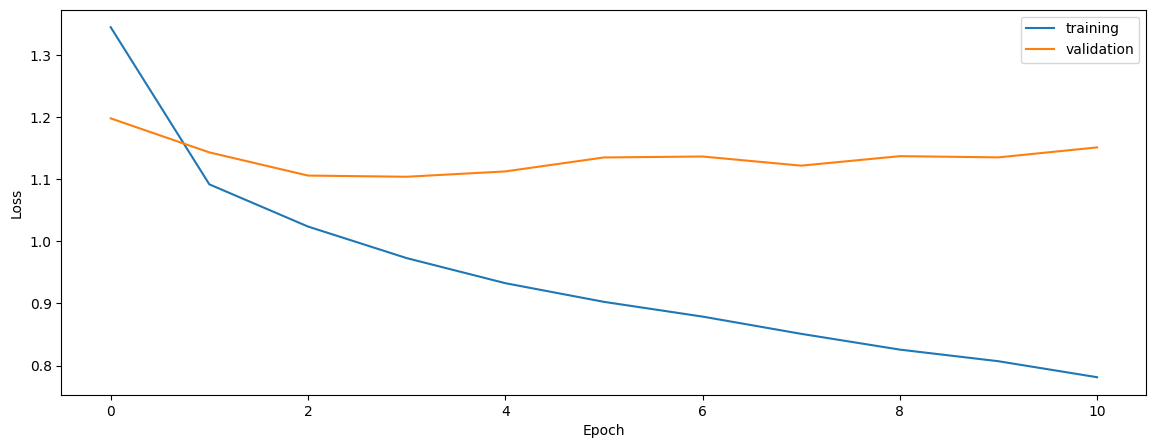

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(788651, 832)
(788651, 1)
validation
(140101, 832)
(140101, 1)
test
(66093, 832)
(66093, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 832)]             0         


 dense_5 (Dense)             (None, 1024)              852992    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/79 [..............................] - ETA: 1:59 - loss: 0.2825 - STD: 1.1815e-04 - MAE: 0.5068

 4/79 [>.............................] - ETA: 1s - loss: 0.2436 - STD: 3.7734e-04 - MAE: 0.4474  

 7/79 [=>............................] - ETA: 1s - loss: 0.2374 - STD: 5.6156e-04 - MAE: 0.4369

10/79 [==>...........................] - ETA: 1s - loss: 0.2325 - STD: 8.1784e-04 - MAE: 0.4425

13/79 [===>..........................] - ETA: 1s - loss: 0.2303 - STD: 0.0010 - MAE: 0.4470    

16/79 [=====>........................] - ETA: 1s - loss: 0.2281 - STD: 0.0013 - MAE: 0.4464

19/79 [======>.......................] - ETA: 1s - loss: 0.2268 - STD: 0.0015 - MAE: 0.4440

22/79 [=======>......................] - ETA: 1s - loss: 0.2257 - STD: 0.0017 - MAE: 0.4429

25/79 [========>.....................] - ETA: 1s - loss: 0.2246 - STD: 0.0021 - MAE: 0.4432

28/79 [=========>....................] - ETA: 1s - loss: 0.2237 - STD: 0.0026 - MAE: 0.4438

31/79 [==========>...................] - ETA: 1s - loss: 0.2228 - STD: 0.0032 - MAE: 0.4436

34/79 [===========>..................] - ETA: 1s - loss: 0.2221 - STD: 0.0040 - MAE: 0.4428

37/79 [=============>................] - ETA: 0s - loss: 0.2212 - STD: 0.0053 - MAE: 0.4419

40/79 [==============>...............] - ETA: 0s - loss: 0.2202 - STD: 0.0071 - MAE: 0.4414

43/79 [===============>..............] - ETA: 0s - loss: 0.2192 - STD: 0.0098 - MAE: 0.4406

46/79 [================>.............] - ETA: 0s - loss: 0.2179 - STD: 0.0136 - MAE: 0.4391

49/79 [=================>............] - ETA: 0s - loss: 0.2164 - STD: 0.0189 - MAE: 0.4370

52/79 [==================>...........] - ETA: 0s - loss: 0.2148 - STD: 0.0255 - MAE: 0.4346

55/79 [===================>..........] - ETA: 0s - loss: 0.2135 - STD: 0.0326 - MAE: 0.4319

58/79 [=====================>........] - ETA: 0s - loss: 0.2121 - STD: 0.0397 - MAE: 0.4292

61/79 [======================>.......] - ETA: 0s - loss: 0.2107 - STD: 0.0462 - MAE: 0.4268

64/79 [=======================>......] - ETA: 0s - loss: 0.2094 - STD: 0.0517 - MAE: 0.4246

67/79 [========================>.....] - ETA: 0s - loss: 0.2083 - STD: 0.0571 - MAE: 0.4224

70/79 [=========================>....] - ETA: 0s - loss: 0.2072 - STD: 0.0623 - MAE: 0.4203

73/79 [==========================>...] - ETA: 0s - loss: 0.2062 - STD: 0.0673 - MAE: 0.4183

76/79 [===========================>..] - ETA: 0s - loss: 0.2052 - STD: 0.0719 - MAE: 0.4164

79/79 [==============================] - ETA: 0s - loss: 0.2043 - STD: 0.0759 - MAE: 0.4148

79/79 [==============================] - 5s 43ms/step - loss: 0.2043 - STD: 0.0759 - MAE: 0.4148 - val_loss: 0.1863 - val_STD: 0.1191 - val_MAE: 0.3767


Epoch 2/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1791 - STD: 0.1801 - MAE: 0.3706

 4/79 [>.............................] - ETA: 1s - loss: 0.1813 - STD: 0.1848 - MAE: 0.3714

 7/79 [=>............................] - ETA: 1s - loss: 0.1811 - STD: 0.1820 - MAE: 0.3711

10/79 [==>...........................] - ETA: 1s - loss: 0.1813 - STD: 0.1829 - MAE: 0.3716

13/79 [===>..........................] - ETA: 1s - loss: 0.1812 - STD: 0.1821 - MAE: 0.3713

16/79 [=====>........................] - ETA: 1s - loss: 0.1809 - STD: 0.1831 - MAE: 0.3710

19/79 [======>.......................] - ETA: 1s - loss: 0.1808 - STD: 0.1827 - MAE: 0.3707

22/79 [=======>......................] - ETA: 1s - loss: 0.1803 - STD: 0.1841 - MAE: 0.3698

25/79 [========>.....................] - ETA: 1s - loss: 0.1801 - STD: 0.1843 - MAE: 0.3694

28/79 [=========>....................] - ETA: 1s - loss: 0.1799 - STD: 0.1850 - MAE: 0.3690

31/79 [==========>...................] - ETA: 1s - loss: 0.1796 - STD: 0.1850 - MAE: 0.3687

34/79 [===========>..................] - ETA: 1s - loss: 0.1795 - STD: 0.1853 - MAE: 0.3685

37/79 [=============>................] - ETA: 0s - loss: 0.1792 - STD: 0.1856 - MAE: 0.3682

40/79 [==============>...............] - ETA: 0s - loss: 0.1790 - STD: 0.1859 - MAE: 0.3677

43/79 [===============>..............] - ETA: 0s - loss: 0.1787 - STD: 0.1864 - MAE: 0.3673

46/79 [================>.............] - ETA: 0s - loss: 0.1785 - STD: 0.1865 - MAE: 0.3671

49/79 [=================>............] - ETA: 0s - loss: 0.1783 - STD: 0.1866 - MAE: 0.3669

52/79 [==================>...........] - ETA: 0s - loss: 0.1781 - STD: 0.1870 - MAE: 0.3667

55/79 [===================>..........] - ETA: 0s - loss: 0.1779 - STD: 0.1876 - MAE: 0.3662

58/79 [=====================>........] - ETA: 0s - loss: 0.1776 - STD: 0.1878 - MAE: 0.3657

61/79 [======================>.......] - ETA: 0s - loss: 0.1774 - STD: 0.1884 - MAE: 0.3654

64/79 [=======================>......] - ETA: 0s - loss: 0.1771 - STD: 0.1890 - MAE: 0.3650

67/79 [========================>.....] - ETA: 0s - loss: 0.1769 - STD: 0.1897 - MAE: 0.3646

70/79 [=========================>....] - ETA: 0s - loss: 0.1766 - STD: 0.1907 - MAE: 0.3642

73/79 [==========================>...] - ETA: 0s - loss: 0.1764 - STD: 0.1916 - MAE: 0.3635

76/79 [===========================>..] - ETA: 0s - loss: 0.1762 - STD: 0.1924 - MAE: 0.3630

79/79 [==============================] - ETA: 0s - loss: 0.1760 - STD: 0.1931 - MAE: 0.3624

79/79 [==============================] - 2s 26ms/step - loss: 0.1760 - STD: 0.1931 - MAE: 0.3624 - val_loss: 0.1756 - val_STD: 0.1511 - val_MAE: 0.3647


Epoch 3/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1723 - STD: 0.2131 - MAE: 0.3585

 4/79 [>.............................] - ETA: 1s - loss: 0.1710 - STD: 0.2084 - MAE: 0.3541

 7/79 [=>............................] - ETA: 1s - loss: 0.1698 - STD: 0.2068 - MAE: 0.3534

10/79 [==>...........................] - ETA: 1s - loss: 0.1695 - STD: 0.2084 - MAE: 0.3528

13/79 [===>..........................] - ETA: 1s - loss: 0.1697 - STD: 0.2102 - MAE: 0.3518

16/79 [=====>........................] - ETA: 1s - loss: 0.1696 - STD: 0.2100 - MAE: 0.3517

19/79 [======>.......................] - ETA: 1s - loss: 0.1691 - STD: 0.2095 - MAE: 0.3514

22/79 [=======>......................] - ETA: 1s - loss: 0.1691 - STD: 0.2101 - MAE: 0.3513

25/79 [========>.....................] - ETA: 1s - loss: 0.1690 - STD: 0.2109 - MAE: 0.3509

28/79 [=========>....................] - ETA: 1s - loss: 0.1691 - STD: 0.2110 - MAE: 0.3508

31/79 [==========>...................] - ETA: 1s - loss: 0.1690 - STD: 0.2111 - MAE: 0.3506

34/79 [===========>..................] - ETA: 1s - loss: 0.1687 - STD: 0.2121 - MAE: 0.3501

37/79 [=============>................] - ETA: 0s - loss: 0.1687 - STD: 0.2128 - MAE: 0.3498

40/79 [==============>...............] - ETA: 0s - loss: 0.1686 - STD: 0.2130 - MAE: 0.3497

43/79 [===============>..............] - ETA: 0s - loss: 0.1685 - STD: 0.2130 - MAE: 0.3496

46/79 [================>.............] - ETA: 0s - loss: 0.1684 - STD: 0.2132 - MAE: 0.3492

49/79 [=================>............] - ETA: 0s - loss: 0.1682 - STD: 0.2135 - MAE: 0.3488

52/79 [==================>...........] - ETA: 0s - loss: 0.1681 - STD: 0.2139 - MAE: 0.3486

55/79 [===================>..........] - ETA: 0s - loss: 0.1681 - STD: 0.2141 - MAE: 0.3487

58/79 [=====================>........] - ETA: 0s - loss: 0.1681 - STD: 0.2142 - MAE: 0.3487

61/79 [======================>.......] - ETA: 0s - loss: 0.1681 - STD: 0.2143 - MAE: 0.3486

64/79 [=======================>......] - ETA: 0s - loss: 0.1681 - STD: 0.2144 - MAE: 0.3485

67/79 [========================>.....] - ETA: 0s - loss: 0.1680 - STD: 0.2146 - MAE: 0.3482

70/79 [=========================>....] - ETA: 0s - loss: 0.1680 - STD: 0.2148 - MAE: 0.3481

73/79 [==========================>...] - ETA: 0s - loss: 0.1678 - STD: 0.2150 - MAE: 0.3479

76/79 [===========================>..] - ETA: 0s - loss: 0.1677 - STD: 0.2152 - MAE: 0.3477

79/79 [==============================] - ETA: 0s - loss: 0.1676 - STD: 0.2156 - MAE: 0.3474

79/79 [==============================] - 2s 26ms/step - loss: 0.1676 - STD: 0.2156 - MAE: 0.3474 - val_loss: 0.1714 - val_STD: 0.1659 - val_MAE: 0.3593


Epoch 4/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1646 - STD: 0.2226 - MAE: 0.3473

 4/79 [>.............................] - ETA: 1s - loss: 0.1662 - STD: 0.2190 - MAE: 0.3450

 7/79 [=>............................] - ETA: 1s - loss: 0.1662 - STD: 0.2192 - MAE: 0.3447

10/79 [==>...........................] - ETA: 1s - loss: 0.1665 - STD: 0.2207 - MAE: 0.3448

13/79 [===>..........................] - ETA: 1s - loss: 0.1662 - STD: 0.2200 - MAE: 0.3448

16/79 [=====>........................] - ETA: 1s - loss: 0.1657 - STD: 0.2196 - MAE: 0.3446

19/79 [======>.......................] - ETA: 1s - loss: 0.1657 - STD: 0.2205 - MAE: 0.3440

22/79 [=======>......................] - ETA: 1s - loss: 0.1652 - STD: 0.2211 - MAE: 0.3430

25/79 [========>.....................] - ETA: 1s - loss: 0.1652 - STD: 0.2214 - MAE: 0.3431

28/79 [=========>....................] - ETA: 1s - loss: 0.1651 - STD: 0.2218 - MAE: 0.3429

31/79 [==========>...................] - ETA: 1s - loss: 0.1650 - STD: 0.2225 - MAE: 0.3425

34/79 [===========>..................] - ETA: 1s - loss: 0.1649 - STD: 0.2227 - MAE: 0.3424

37/79 [=============>................] - ETA: 0s - loss: 0.1649 - STD: 0.2227 - MAE: 0.3425

40/79 [==============>...............] - ETA: 0s - loss: 0.1649 - STD: 0.2231 - MAE: 0.3423

43/79 [===============>..............] - ETA: 0s - loss: 0.1649 - STD: 0.2234 - MAE: 0.3422

46/79 [================>.............] - ETA: 0s - loss: 0.1647 - STD: 0.2234 - MAE: 0.3420

49/79 [=================>............] - ETA: 0s - loss: 0.1648 - STD: 0.2233 - MAE: 0.3420

52/79 [==================>...........] - ETA: 0s - loss: 0.1648 - STD: 0.2235 - MAE: 0.3418

55/79 [===================>..........] - ETA: 0s - loss: 0.1648 - STD: 0.2236 - MAE: 0.3418

58/79 [=====================>........] - ETA: 0s - loss: 0.1647 - STD: 0.2235 - MAE: 0.3418

61/79 [======================>.......] - ETA: 0s - loss: 0.1646 - STD: 0.2236 - MAE: 0.3418

64/79 [=======================>......] - ETA: 0s - loss: 0.1646 - STD: 0.2240 - MAE: 0.3416

67/79 [========================>.....] - ETA: 0s - loss: 0.1645 - STD: 0.2241 - MAE: 0.3414

70/79 [=========================>....] - ETA: 0s - loss: 0.1644 - STD: 0.2243 - MAE: 0.3413

73/79 [==========================>...] - ETA: 0s - loss: 0.1643 - STD: 0.2244 - MAE: 0.3411

76/79 [===========================>..] - ETA: 0s - loss: 0.1643 - STD: 0.2245 - MAE: 0.3410

79/79 [==============================] - ETA: 0s - loss: 0.1642 - STD: 0.2247 - MAE: 0.3410

79/79 [==============================] - 2s 26ms/step - loss: 0.1642 - STD: 0.2247 - MAE: 0.3410 - val_loss: 0.1682 - val_STD: 0.1661 - val_MAE: 0.3449


Epoch 5/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1603 - STD: 0.2281 - MAE: 0.3344

 4/79 [>.............................] - ETA: 1s - loss: 0.1601 - STD: 0.2311 - MAE: 0.3342

 7/79 [=>............................] - ETA: 1s - loss: 0.1608 - STD: 0.2313 - MAE: 0.3349

10/79 [==>...........................] - ETA: 1s - loss: 0.1609 - STD: 0.2316 - MAE: 0.3348

13/79 [===>..........................] - ETA: 1s - loss: 0.1616 - STD: 0.2320 - MAE: 0.3352

16/79 [=====>........................] - ETA: 1s - loss: 0.1620 - STD: 0.2326 - MAE: 0.3352

19/79 [======>.......................] - ETA: 1s - loss: 0.1622 - STD: 0.2325 - MAE: 0.3353

22/79 [=======>......................] - ETA: 1s - loss: 0.1622 - STD: 0.2319 - MAE: 0.3355

25/79 [========>.....................] - ETA: 1s - loss: 0.1621 - STD: 0.2318 - MAE: 0.3357

28/79 [=========>....................] - ETA: 1s - loss: 0.1620 - STD: 0.2315 - MAE: 0.3359

31/79 [==========>...................] - ETA: 1s - loss: 0.1621 - STD: 0.2311 - MAE: 0.3363

34/79 [===========>..................] - ETA: 1s - loss: 0.1621 - STD: 0.2309 - MAE: 0.3364

37/79 [=============>................] - ETA: 0s - loss: 0.1621 - STD: 0.2309 - MAE: 0.3365

40/79 [==============>...............] - ETA: 0s - loss: 0.1618 - STD: 0.2312 - MAE: 0.3361

43/79 [===============>..............] - ETA: 0s - loss: 0.1617 - STD: 0.2315 - MAE: 0.3358

46/79 [================>.............] - ETA: 0s - loss: 0.1619 - STD: 0.2316 - MAE: 0.3357

49/79 [=================>............] - ETA: 0s - loss: 0.1622 - STD: 0.2316 - MAE: 0.3358

52/79 [==================>...........] - ETA: 0s - loss: 0.1626 - STD: 0.2318 - MAE: 0.3361

55/79 [===================>..........] - ETA: 0s - loss: 0.1627 - STD: 0.2316 - MAE: 0.3359

58/79 [=====================>........] - ETA: 0s - loss: 0.1627 - STD: 0.2310 - MAE: 0.3362

61/79 [======================>.......] - ETA: 0s - loss: 0.1626 - STD: 0.2305 - MAE: 0.3365

64/79 [=======================>......] - ETA: 0s - loss: 0.1626 - STD: 0.2304 - MAE: 0.3364

67/79 [========================>.....] - ETA: 0s - loss: 0.1626 - STD: 0.2305 - MAE: 0.3364

70/79 [=========================>....] - ETA: 0s - loss: 0.1626 - STD: 0.2304 - MAE: 0.3365

73/79 [==========================>...] - ETA: 0s - loss: 0.1625 - STD: 0.2302 - MAE: 0.3365

76/79 [===========================>..] - ETA: 0s - loss: 0.1624 - STD: 0.2303 - MAE: 0.3364

79/79 [==============================] - ETA: 0s - loss: 0.1624 - STD: 0.2302 - MAE: 0.3363

79/79 [==============================] - 2s 26ms/step - loss: 0.1624 - STD: 0.2302 - MAE: 0.3363 - val_loss: 0.1643 - val_STD: 0.1708 - val_MAE: 0.3497


Epoch 6/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1615 - STD: 0.2296 - MAE: 0.3408

 4/79 [>.............................] - ETA: 1s - loss: 0.1596 - STD: 0.2320 - MAE: 0.3347

 7/79 [=>............................] - ETA: 1s - loss: 0.1599 - STD: 0.2360 - MAE: 0.3333

10/79 [==>...........................] - ETA: 1s - loss: 0.1594 - STD: 0.2376 - MAE: 0.3323

13/79 [===>..........................] - ETA: 1s - loss: 0.1595 - STD: 0.2368 - MAE: 0.3327

16/79 [=====>........................] - ETA: 1s - loss: 0.1597 - STD: 0.2365 - MAE: 0.3328

19/79 [======>.......................] - ETA: 1s - loss: 0.1597 - STD: 0.2365 - MAE: 0.3325

22/79 [=======>......................] - ETA: 1s - loss: 0.1596 - STD: 0.2366 - MAE: 0.3324

25/79 [========>.....................] - ETA: 1s - loss: 0.1597 - STD: 0.2361 - MAE: 0.3327

28/79 [=========>....................] - ETA: 1s - loss: 0.1596 - STD: 0.2358 - MAE: 0.3327

31/79 [==========>...................] - ETA: 1s - loss: 0.1596 - STD: 0.2363 - MAE: 0.3326

34/79 [===========>..................] - ETA: 1s - loss: 0.1597 - STD: 0.2363 - MAE: 0.3326

37/79 [=============>................] - ETA: 0s - loss: 0.1598 - STD: 0.2363 - MAE: 0.3326

40/79 [==============>...............] - ETA: 0s - loss: 0.1601 - STD: 0.2369 - MAE: 0.3325

43/79 [===============>..............] - ETA: 0s - loss: 0.1602 - STD: 0.2370 - MAE: 0.3325

46/79 [================>.............] - ETA: 0s - loss: 0.1603 - STD: 0.2363 - MAE: 0.3329

49/79 [=================>............] - ETA: 0s - loss: 0.1603 - STD: 0.2359 - MAE: 0.3328

52/79 [==================>...........] - ETA: 0s - loss: 0.1603 - STD: 0.2360 - MAE: 0.3327

55/79 [===================>..........] - ETA: 0s - loss: 0.1603 - STD: 0.2358 - MAE: 0.3328

58/79 [=====================>........] - ETA: 0s - loss: 0.1602 - STD: 0.2355 - MAE: 0.3329

61/79 [======================>.......] - ETA: 0s - loss: 0.1602 - STD: 0.2355 - MAE: 0.3329

64/79 [=======================>......] - ETA: 0s - loss: 0.1601 - STD: 0.2355 - MAE: 0.3328

67/79 [========================>.....] - ETA: 0s - loss: 0.1601 - STD: 0.2353 - MAE: 0.3328

70/79 [=========================>....] - ETA: 0s - loss: 0.1600 - STD: 0.2355 - MAE: 0.3327

73/79 [==========================>...] - ETA: 0s - loss: 0.1599 - STD: 0.2359 - MAE: 0.3324

76/79 [===========================>..] - ETA: 0s - loss: 0.1599 - STD: 0.2361 - MAE: 0.3324

79/79 [==============================] - ETA: 0s - loss: 0.1598 - STD: 0.2360 - MAE: 0.3324

79/79 [==============================] - 2s 26ms/step - loss: 0.1598 - STD: 0.2360 - MAE: 0.3324 - val_loss: 0.1676 - val_STD: 0.1668 - val_MAE: 0.3345


Epoch 7/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1607 - STD: 0.2342 - MAE: 0.3281

 4/79 [>.............................] - ETA: 1s - loss: 0.1587 - STD: 0.2418 - MAE: 0.3276

 7/79 [=>............................] - ETA: 1s - loss: 0.1591 - STD: 0.2417 - MAE: 0.3290

10/79 [==>...........................] - ETA: 1s - loss: 0.1588 - STD: 0.2396 - MAE: 0.3297

13/79 [===>..........................] - ETA: 1s - loss: 0.1587 - STD: 0.2392 - MAE: 0.3290

16/79 [=====>........................] - ETA: 1s - loss: 0.1591 - STD: 0.2401 - MAE: 0.3289

19/79 [======>.......................] - ETA: 1s - loss: 0.1589 - STD: 0.2385 - MAE: 0.3296

22/79 [=======>......................] - ETA: 1s - loss: 0.1588 - STD: 0.2379 - MAE: 0.3300

25/79 [========>.....................] - ETA: 1s - loss: 0.1588 - STD: 0.2386 - MAE: 0.3298

28/79 [=========>....................] - ETA: 1s - loss: 0.1590 - STD: 0.2387 - MAE: 0.3300

31/79 [==========>...................] - ETA: 1s - loss: 0.1592 - STD: 0.2380 - MAE: 0.3304

34/79 [===========>..................] - ETA: 1s - loss: 0.1594 - STD: 0.2379 - MAE: 0.3304

37/79 [=============>................] - ETA: 0s - loss: 0.1595 - STD: 0.2380 - MAE: 0.3306

40/79 [==============>...............] - ETA: 0s - loss: 0.1594 - STD: 0.2376 - MAE: 0.3307

43/79 [===============>..............] - ETA: 0s - loss: 0.1592 - STD: 0.2373 - MAE: 0.3307

46/79 [================>.............] - ETA: 0s - loss: 0.1592 - STD: 0.2375 - MAE: 0.3307

49/79 [=================>............] - ETA: 0s - loss: 0.1590 - STD: 0.2378 - MAE: 0.3305

52/79 [==================>...........] - ETA: 0s - loss: 0.1590 - STD: 0.2378 - MAE: 0.3306

55/79 [===================>..........] - ETA: 0s - loss: 0.1588 - STD: 0.2379 - MAE: 0.3304

58/79 [=====================>........] - ETA: 0s - loss: 0.1587 - STD: 0.2383 - MAE: 0.3301

61/79 [======================>.......] - ETA: 0s - loss: 0.1586 - STD: 0.2385 - MAE: 0.3300

64/79 [=======================>......] - ETA: 0s - loss: 0.1585 - STD: 0.2387 - MAE: 0.3299

67/79 [========================>.....] - ETA: 0s - loss: 0.1585 - STD: 0.2391 - MAE: 0.3297

70/79 [=========================>....] - ETA: 0s - loss: 0.1584 - STD: 0.2393 - MAE: 0.3295

73/79 [==========================>...] - ETA: 0s - loss: 0.1584 - STD: 0.2394 - MAE: 0.3295

76/79 [===========================>..] - ETA: 0s - loss: 0.1585 - STD: 0.2397 - MAE: 0.3293

79/79 [==============================] - ETA: 0s - loss: 0.1584 - STD: 0.2399 - MAE: 0.3291

79/79 [==============================] - 2s 26ms/step - loss: 0.1584 - STD: 0.2399 - MAE: 0.3291 - val_loss: 0.1615 - val_STD: 0.1755 - val_MAE: 0.3460


Epoch 8/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1573 - STD: 0.2362 - MAE: 0.3353

 4/79 [>.............................] - ETA: 1s - loss: 0.1560 - STD: 0.2356 - MAE: 0.3301

 7/79 [=>............................] - ETA: 1s - loss: 0.1572 - STD: 0.2371 - MAE: 0.3304

10/79 [==>...........................] - ETA: 1s - loss: 0.1573 - STD: 0.2383 - MAE: 0.3300

13/79 [===>..........................] - ETA: 1s - loss: 0.1574 - STD: 0.2377 - MAE: 0.3302

16/79 [=====>........................] - ETA: 1s - loss: 0.1572 - STD: 0.2385 - MAE: 0.3294

19/79 [======>.......................] - ETA: 1s - loss: 0.1567 - STD: 0.2398 - MAE: 0.3282

22/79 [=======>......................] - ETA: 1s - loss: 0.1568 - STD: 0.2402 - MAE: 0.3280

25/79 [========>.....................] - ETA: 1s - loss: 0.1570 - STD: 0.2403 - MAE: 0.3281

28/79 [=========>....................] - ETA: 1s - loss: 0.1568 - STD: 0.2408 - MAE: 0.3277

31/79 [==========>...................] - ETA: 1s - loss: 0.1569 - STD: 0.2413 - MAE: 0.3277

34/79 [===========>..................] - ETA: 1s - loss: 0.1567 - STD: 0.2414 - MAE: 0.3274

37/79 [=============>................] - ETA: 0s - loss: 0.1566 - STD: 0.2419 - MAE: 0.3272

40/79 [==============>...............] - ETA: 0s - loss: 0.1565 - STD: 0.2425 - MAE: 0.3268

43/79 [===============>..............] - ETA: 0s - loss: 0.1567 - STD: 0.2424 - MAE: 0.3269

46/79 [================>.............] - ETA: 0s - loss: 0.1567 - STD: 0.2424 - MAE: 0.3268

49/79 [=================>............] - ETA: 0s - loss: 0.1566 - STD: 0.2428 - MAE: 0.3267

52/79 [==================>...........] - ETA: 0s - loss: 0.1565 - STD: 0.2426 - MAE: 0.3267

55/79 [===================>..........] - ETA: 0s - loss: 0.1564 - STD: 0.2425 - MAE: 0.3265

58/79 [=====================>........] - ETA: 0s - loss: 0.1566 - STD: 0.2427 - MAE: 0.3265

61/79 [======================>.......] - ETA: 0s - loss: 0.1567 - STD: 0.2427 - MAE: 0.3265

64/79 [=======================>......] - ETA: 0s - loss: 0.1569 - STD: 0.2428 - MAE: 0.3265

67/79 [========================>.....] - ETA: 0s - loss: 0.1570 - STD: 0.2427 - MAE: 0.3265

70/79 [=========================>....] - ETA: 0s - loss: 0.1571 - STD: 0.2423 - MAE: 0.3267

73/79 [==========================>...] - ETA: 0s - loss: 0.1571 - STD: 0.2420 - MAE: 0.3269

76/79 [===========================>..] - ETA: 0s - loss: 0.1572 - STD: 0.2417 - MAE: 0.3271

79/79 [==============================] - ETA: 0s - loss: 0.1572 - STD: 0.2415 - MAE: 0.3271

79/79 [==============================] - 2s 26ms/step - loss: 0.1572 - STD: 0.2415 - MAE: 0.3271 - val_loss: 0.1599 - val_STD: 0.1777 - val_MAE: 0.3365


Epoch 9/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1589 - STD: 0.2477 - MAE: 0.3301

 4/79 [>.............................] - ETA: 1s - loss: 0.1590 - STD: 0.2418 - MAE: 0.3287

 7/79 [=>............................] - ETA: 1s - loss: 0.1584 - STD: 0.2399 - MAE: 0.3297

10/79 [==>...........................] - ETA: 1s - loss: 0.1571 - STD: 0.2413 - MAE: 0.3277

13/79 [===>..........................] - ETA: 1s - loss: 0.1566 - STD: 0.2425 - MAE: 0.3269

16/79 [=====>........................] - ETA: 1s - loss: 0.1560 - STD: 0.2427 - MAE: 0.3261

19/79 [======>.......................] - ETA: 1s - loss: 0.1558 - STD: 0.2430 - MAE: 0.3257

22/79 [=======>......................] - ETA: 1s - loss: 0.1556 - STD: 0.2436 - MAE: 0.3252

25/79 [========>.....................] - ETA: 1s - loss: 0.1556 - STD: 0.2440 - MAE: 0.3251

28/79 [=========>....................] - ETA: 1s - loss: 0.1555 - STD: 0.2442 - MAE: 0.3249

31/79 [==========>...................] - ETA: 1s - loss: 0.1556 - STD: 0.2446 - MAE: 0.3249

34/79 [===========>..................] - ETA: 1s - loss: 0.1557 - STD: 0.2446 - MAE: 0.3250

37/79 [=============>................] - ETA: 0s - loss: 0.1558 - STD: 0.2446 - MAE: 0.3251

40/79 [==============>...............] - ETA: 0s - loss: 0.1560 - STD: 0.2443 - MAE: 0.3252

43/79 [===============>..............] - ETA: 0s - loss: 0.1561 - STD: 0.2443 - MAE: 0.3253

46/79 [================>.............] - ETA: 0s - loss: 0.1561 - STD: 0.2447 - MAE: 0.3251

49/79 [=================>............] - ETA: 0s - loss: 0.1563 - STD: 0.2441 - MAE: 0.3255

52/79 [==================>...........] - ETA: 0s - loss: 0.1564 - STD: 0.2437 - MAE: 0.3256

55/79 [===================>..........] - ETA: 0s - loss: 0.1564 - STD: 0.2440 - MAE: 0.3252

58/79 [=====================>........] - ETA: 0s - loss: 0.1565 - STD: 0.2438 - MAE: 0.3253

61/79 [======================>.......] - ETA: 0s - loss: 0.1566 - STD: 0.2435 - MAE: 0.3256

64/79 [=======================>......] - ETA: 0s - loss: 0.1565 - STD: 0.2435 - MAE: 0.3256

67/79 [========================>.....] - ETA: 0s - loss: 0.1564 - STD: 0.2435 - MAE: 0.3256

70/79 [=========================>....] - ETA: 0s - loss: 0.1563 - STD: 0.2433 - MAE: 0.3256

73/79 [==========================>...] - ETA: 0s - loss: 0.1562 - STD: 0.2435 - MAE: 0.3254

76/79 [===========================>..] - ETA: 0s - loss: 0.1561 - STD: 0.2439 - MAE: 0.3251

79/79 [==============================] - ETA: 0s - loss: 0.1560 - STD: 0.2441 - MAE: 0.3249

79/79 [==============================] - 2s 26ms/step - loss: 0.1560 - STD: 0.2441 - MAE: 0.3249 - val_loss: 0.1606 - val_STD: 0.1813 - val_MAE: 0.3346


Epoch 10/10000


 1/79 [..............................] - ETA: 2s - loss: 0.1534 - STD: 0.2502 - MAE: 0.3234

 4/79 [>.............................] - ETA: 1s - loss: 0.1537 - STD: 0.2480 - MAE: 0.3221

 7/79 [=>............................] - ETA: 1s - loss: 0.1538 - STD: 0.2489 - MAE: 0.3214

10/79 [==>...........................] - ETA: 1s - loss: 0.1540 - STD: 0.2491 - MAE: 0.3214

13/79 [===>..........................] - ETA: 1s - loss: 0.1547 - STD: 0.2496 - MAE: 0.3222

16/79 [=====>........................] - ETA: 1s - loss: 0.1549 - STD: 0.2493 - MAE: 0.3227

19/79 [======>.......................] - ETA: 1s - loss: 0.1549 - STD: 0.2490 - MAE: 0.3227

22/79 [=======>......................] - ETA: 1s - loss: 0.1547 - STD: 0.2493 - MAE: 0.3224

25/79 [========>.....................] - ETA: 1s - loss: 0.1545 - STD: 0.2490 - MAE: 0.3223

28/79 [=========>....................] - ETA: 1s - loss: 0.1544 - STD: 0.2488 - MAE: 0.3222

31/79 [==========>...................] - ETA: 1s - loss: 0.1545 - STD: 0.2488 - MAE: 0.3223

34/79 [===========>..................] - ETA: 1s - loss: 0.1544 - STD: 0.2486 - MAE: 0.3223

37/79 [=============>................] - ETA: 0s - loss: 0.1543 - STD: 0.2485 - MAE: 0.3221

40/79 [==============>...............] - ETA: 0s - loss: 0.1542 - STD: 0.2488 - MAE: 0.3219

43/79 [===============>..............] - ETA: 0s - loss: 0.1542 - STD: 0.2487 - MAE: 0.3220

46/79 [================>.............] - ETA: 0s - loss: 0.1542 - STD: 0.2486 - MAE: 0.3220

49/79 [=================>............] - ETA: 0s - loss: 0.1543 - STD: 0.2488 - MAE: 0.3219

52/79 [==================>...........] - ETA: 0s - loss: 0.1541 - STD: 0.2488 - MAE: 0.3218

55/79 [===================>..........] - ETA: 0s - loss: 0.1540 - STD: 0.2487 - MAE: 0.3218

58/79 [=====================>........] - ETA: 0s - loss: 0.1540 - STD: 0.2491 - MAE: 0.3216

61/79 [======================>.......] - ETA: 0s - loss: 0.1539 - STD: 0.2490 - MAE: 0.3216

64/79 [=======================>......] - ETA: 0s - loss: 0.1540 - STD: 0.2491 - MAE: 0.3216

67/79 [========================>.....] - ETA: 0s - loss: 0.1540 - STD: 0.2493 - MAE: 0.3215

70/79 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.2492 - MAE: 0.3215

73/79 [==========================>...] - ETA: 0s - loss: 0.1540 - STD: 0.2492 - MAE: 0.3215

76/79 [===========================>..] - ETA: 0s - loss: 0.1539 - STD: 0.2495 - MAE: 0.3214

79/79 [==============================] - ETA: 0s - loss: 0.1537 - STD: 0.2495 - MAE: 0.3212

79/79 [==============================] - 2s 26ms/step - loss: 0.1537 - STD: 0.2495 - MAE: 0.3212 - val_loss: 0.1623 - val_STD: 0.1812 - val_MAE: 0.3273


Epoch 11/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1509 - STD: 0.2523 - MAE: 0.3143

 4/79 [>.............................] - ETA: 1s - loss: 0.1555 - STD: 0.2511 - MAE: 0.3173

 7/79 [=>............................] - ETA: 1s - loss: 0.1613 - STD: 0.2501 - MAE: 0.3212

10/79 [==>...........................] - ETA: 1s - loss: 0.1633 - STD: 0.2521 - MAE: 0.3218

13/79 [===>..........................] - ETA: 1s - loss: 0.1646 - STD: 0.2504 - MAE: 0.3239

16/79 [=====>........................] - ETA: 1s - loss: 0.1636 - STD: 0.2450 - MAE: 0.3248

19/79 [======>.......................] - ETA: 1s - loss: 0.1632 - STD: 0.2408 - MAE: 0.3269

22/79 [=======>......................] - ETA: 1s - loss: 0.1628 - STD: 0.2396 - MAE: 0.3281

25/79 [========>.....................] - ETA: 1s - loss: 0.1622 - STD: 0.2386 - MAE: 0.3275

28/79 [=========>....................] - ETA: 1s - loss: 0.1619 - STD: 0.2375 - MAE: 0.3286

31/79 [==========>...................] - ETA: 1s - loss: 0.1614 - STD: 0.2365 - MAE: 0.3290

34/79 [===========>..................] - ETA: 1s - loss: 0.1608 - STD: 0.2364 - MAE: 0.3284

37/79 [=============>................] - ETA: 0s - loss: 0.1604 - STD: 0.2373 - MAE: 0.3282

40/79 [==============>...............] - ETA: 0s - loss: 0.1599 - STD: 0.2376 - MAE: 0.3278

43/79 [===============>..............] - ETA: 0s - loss: 0.1595 - STD: 0.2380 - MAE: 0.3273

46/79 [================>.............] - ETA: 0s - loss: 0.1591 - STD: 0.2389 - MAE: 0.3268

49/79 [=================>............] - ETA: 0s - loss: 0.1588 - STD: 0.2400 - MAE: 0.3263

52/79 [==================>...........] - ETA: 0s - loss: 0.1585 - STD: 0.2407 - MAE: 0.3260

55/79 [===================>..........] - ETA: 0s - loss: 0.1582 - STD: 0.2410 - MAE: 0.3258

58/79 [=====================>........] - ETA: 0s - loss: 0.1580 - STD: 0.2414 - MAE: 0.3255

61/79 [======================>.......] - ETA: 0s - loss: 0.1578 - STD: 0.2417 - MAE: 0.3253

64/79 [=======================>......] - ETA: 0s - loss: 0.1575 - STD: 0.2419 - MAE: 0.3252

67/79 [========================>.....] - ETA: 0s - loss: 0.1573 - STD: 0.2422 - MAE: 0.3250

70/79 [=========================>....] - ETA: 0s - loss: 0.1571 - STD: 0.2427 - MAE: 0.3248

73/79 [==========================>...] - ETA: 0s - loss: 0.1570 - STD: 0.2430 - MAE: 0.3245

76/79 [===========================>..] - ETA: 0s - loss: 0.1568 - STD: 0.2434 - MAE: 0.3243

79/79 [==============================] - ETA: 0s - loss: 0.1567 - STD: 0.2437 - MAE: 0.3242

79/79 [==============================] - 2s 26ms/step - loss: 0.1567 - STD: 0.2437 - MAE: 0.3242 - val_loss: 0.1599 - val_STD: 0.1822 - val_MAE: 0.3296


Epoch 12/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1516 - STD: 0.2507 - MAE: 0.3179

 4/79 [>.............................] - ETA: 1s - loss: 0.1523 - STD: 0.2515 - MAE: 0.3189

 7/79 [=>............................] - ETA: 1s - loss: 0.1526 - STD: 0.2521 - MAE: 0.3194

10/79 [==>...........................] - ETA: 1s - loss: 0.1523 - STD: 0.2508 - MAE: 0.3194

13/79 [===>..........................] - ETA: 1s - loss: 0.1522 - STD: 0.2507 - MAE: 0.3192

16/79 [=====>........................] - ETA: 1s - loss: 0.1520 - STD: 0.2511 - MAE: 0.3188

19/79 [======>.......................] - ETA: 1s - loss: 0.1523 - STD: 0.2513 - MAE: 0.3192

22/79 [=======>......................] - ETA: 1s - loss: 0.1523 - STD: 0.2516 - MAE: 0.3191

25/79 [========>.....................] - ETA: 1s - loss: 0.1522 - STD: 0.2518 - MAE: 0.3188

28/79 [=========>....................] - ETA: 1s - loss: 0.1522 - STD: 0.2524 - MAE: 0.3186

31/79 [==========>...................] - ETA: 1s - loss: 0.1523 - STD: 0.2525 - MAE: 0.3186

34/79 [===========>..................] - ETA: 1s - loss: 0.1521 - STD: 0.2528 - MAE: 0.3184

37/79 [=============>................] - ETA: 0s - loss: 0.1521 - STD: 0.2530 - MAE: 0.3183

40/79 [==============>...............] - ETA: 0s - loss: 0.1521 - STD: 0.2531 - MAE: 0.3183

43/79 [===============>..............] - ETA: 0s - loss: 0.1521 - STD: 0.2532 - MAE: 0.3182

46/79 [================>.............] - ETA: 0s - loss: 0.1520 - STD: 0.2535 - MAE: 0.3180

49/79 [=================>............] - ETA: 0s - loss: 0.1519 - STD: 0.2534 - MAE: 0.3179

52/79 [==================>...........] - ETA: 0s - loss: 0.1519 - STD: 0.2534 - MAE: 0.3178

55/79 [===================>..........] - ETA: 0s - loss: 0.1520 - STD: 0.2535 - MAE: 0.3178

58/79 [=====================>........] - ETA: 0s - loss: 0.1520 - STD: 0.2533 - MAE: 0.3177

61/79 [======================>.......] - ETA: 0s - loss: 0.1523 - STD: 0.2533 - MAE: 0.3177

64/79 [=======================>......] - ETA: 0s - loss: 0.1530 - STD: 0.2530 - MAE: 0.3180

67/79 [========================>.....] - ETA: 0s - loss: 0.1532 - STD: 0.2528 - MAE: 0.3183

70/79 [=========================>....] - ETA: 0s - loss: 0.1533 - STD: 0.2522 - MAE: 0.3187

73/79 [==========================>...] - ETA: 0s - loss: 0.1534 - STD: 0.2518 - MAE: 0.3189

76/79 [===========================>..] - ETA: 0s - loss: 0.1533 - STD: 0.2515 - MAE: 0.3189

79/79 [==============================] - ETA: 0s - loss: 0.1533 - STD: 0.2512 - MAE: 0.3191

79/79 [==============================] - 2s 26ms/step - loss: 0.1533 - STD: 0.2512 - MAE: 0.3191 - val_loss: 0.1598 - val_STD: 0.1734 - val_MAE: 0.3346


Epoch 13/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1514 - STD: 0.2423 - MAE: 0.3223

 4/79 [>.............................] - ETA: 1s - loss: 0.1505 - STD: 0.2454 - MAE: 0.3203

 7/79 [=>............................] - ETA: 1s - loss: 0.1518 - STD: 0.2466 - MAE: 0.3212

10/79 [==>...........................] - ETA: 1s - loss: 0.1522 - STD: 0.2473 - MAE: 0.3209

13/79 [===>..........................] - ETA: 1s - loss: 0.1528 - STD: 0.2482 - MAE: 0.3205

16/79 [=====>........................] - ETA: 1s - loss: 0.1526 - STD: 0.2490 - MAE: 0.3196

19/79 [======>.......................] - ETA: 1s - loss: 0.1524 - STD: 0.2494 - MAE: 0.3196

22/79 [=======>......................] - ETA: 1s - loss: 0.1525 - STD: 0.2499 - MAE: 0.3195

25/79 [========>.....................] - ETA: 1s - loss: 0.1521 - STD: 0.2504 - MAE: 0.3189

28/79 [=========>....................] - ETA: 1s - loss: 0.1520 - STD: 0.2509 - MAE: 0.3185

31/79 [==========>...................] - ETA: 1s - loss: 0.1519 - STD: 0.2512 - MAE: 0.3183

34/79 [===========>..................] - ETA: 1s - loss: 0.1520 - STD: 0.2513 - MAE: 0.3183

37/79 [=============>................] - ETA: 0s - loss: 0.1519 - STD: 0.2516 - MAE: 0.3181

40/79 [==============>...............] - ETA: 0s - loss: 0.1519 - STD: 0.2518 - MAE: 0.3181

43/79 [===============>..............] - ETA: 0s - loss: 0.1518 - STD: 0.2520 - MAE: 0.3180

46/79 [================>.............] - ETA: 0s - loss: 0.1517 - STD: 0.2524 - MAE: 0.3178

49/79 [=================>............] - ETA: 0s - loss: 0.1516 - STD: 0.2526 - MAE: 0.3175

52/79 [==================>...........] - ETA: 0s - loss: 0.1516 - STD: 0.2527 - MAE: 0.3176

55/79 [===================>..........] - ETA: 0s - loss: 0.1515 - STD: 0.2530 - MAE: 0.3173

58/79 [=====================>........] - ETA: 0s - loss: 0.1515 - STD: 0.2533 - MAE: 0.3171

61/79 [======================>.......] - ETA: 0s - loss: 0.1517 - STD: 0.2534 - MAE: 0.3172

64/79 [=======================>......] - ETA: 0s - loss: 0.1519 - STD: 0.2534 - MAE: 0.3172

67/79 [========================>.....] - ETA: 0s - loss: 0.1520 - STD: 0.2532 - MAE: 0.3173

70/79 [=========================>....] - ETA: 0s - loss: 0.1520 - STD: 0.2531 - MAE: 0.3174

73/79 [==========================>...] - ETA: 0s - loss: 0.1520 - STD: 0.2529 - MAE: 0.3175

76/79 [===========================>..] - ETA: 0s - loss: 0.1519 - STD: 0.2529 - MAE: 0.3174

79/79 [==============================] - ETA: 0s - loss: 0.1519 - STD: 0.2528 - MAE: 0.3174

79/79 [==============================] - 2s 26ms/step - loss: 0.1519 - STD: 0.2528 - MAE: 0.3174 - val_loss: 0.1590 - val_STD: 0.1836 - val_MAE: 0.3321


Epoch 14/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1509 - STD: 0.2479 - MAE: 0.3200

 4/79 [>.............................] - ETA: 1s - loss: 0.1483 - STD: 0.2518 - MAE: 0.3146

 7/79 [=>............................] - ETA: 1s - loss: 0.1492 - STD: 0.2550 - MAE: 0.3145

10/79 [==>...........................] - ETA: 1s - loss: 0.1495 - STD: 0.2554 - MAE: 0.3147

13/79 [===>..........................] - ETA: 1s - loss: 0.1500 - STD: 0.2558 - MAE: 0.3147

16/79 [=====>........................] - ETA: 1s - loss: 0.1504 - STD: 0.2561 - MAE: 0.3147

19/79 [======>.......................] - ETA: 1s - loss: 0.1510 - STD: 0.2551 - MAE: 0.3153

22/79 [=======>......................] - ETA: 1s - loss: 0.1514 - STD: 0.2553 - MAE: 0.3154

25/79 [========>.....................] - ETA: 1s - loss: 0.1515 - STD: 0.2554 - MAE: 0.3157

28/79 [=========>....................] - ETA: 1s - loss: 0.1515 - STD: 0.2548 - MAE: 0.3158

31/79 [==========>...................] - ETA: 1s - loss: 0.1513 - STD: 0.2545 - MAE: 0.3160

34/79 [===========>..................] - ETA: 1s - loss: 0.1511 - STD: 0.2548 - MAE: 0.3157

37/79 [=============>................] - ETA: 0s - loss: 0.1510 - STD: 0.2547 - MAE: 0.3156

40/79 [==============>...............] - ETA: 0s - loss: 0.1510 - STD: 0.2547 - MAE: 0.3157

43/79 [===============>..............] - ETA: 0s - loss: 0.1511 - STD: 0.2552 - MAE: 0.3156

46/79 [================>.............] - ETA: 0s - loss: 0.1510 - STD: 0.2552 - MAE: 0.3155

49/79 [=================>............] - ETA: 0s - loss: 0.1510 - STD: 0.2552 - MAE: 0.3155

52/79 [==================>...........] - ETA: 0s - loss: 0.1510 - STD: 0.2553 - MAE: 0.3155

55/79 [===================>..........] - ETA: 0s - loss: 0.1509 - STD: 0.2551 - MAE: 0.3155

58/79 [=====================>........] - ETA: 0s - loss: 0.1509 - STD: 0.2553 - MAE: 0.3154

61/79 [======================>.......] - ETA: 0s - loss: 0.1508 - STD: 0.2554 - MAE: 0.3153

64/79 [=======================>......] - ETA: 0s - loss: 0.1507 - STD: 0.2556 - MAE: 0.3152

67/79 [========================>.....] - ETA: 0s - loss: 0.1507 - STD: 0.2558 - MAE: 0.3151

70/79 [=========================>....] - ETA: 0s - loss: 0.1507 - STD: 0.2558 - MAE: 0.3151

73/79 [==========================>...] - ETA: 0s - loss: 0.1508 - STD: 0.2560 - MAE: 0.3150

76/79 [===========================>..] - ETA: 0s - loss: 0.1512 - STD: 0.2558 - MAE: 0.3151

79/79 [==============================] - ETA: 0s - loss: 0.1523 - STD: 0.2554 - MAE: 0.3155

79/79 [==============================] - 2s 26ms/step - loss: 0.1523 - STD: 0.2554 - MAE: 0.3155 - val_loss: 0.1592 - val_STD: 0.1916 - val_MAE: 0.3240


Epoch 15/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1513 - STD: 0.2719 - MAE: 0.3076

 4/79 [>.............................] - ETA: 1s - loss: 0.1685 - STD: 0.2532 - MAE: 0.3244

 7/79 [=>............................] - ETA: 1s - loss: 0.1654 - STD: 0.2416 - MAE: 0.3303

10/79 [==>...........................] - ETA: 1s - loss: 0.1632 - STD: 0.2340 - MAE: 0.3294

13/79 [===>..........................] - ETA: 1s - loss: 0.1617 - STD: 0.2329 - MAE: 0.3304

16/79 [=====>........................] - ETA: 1s - loss: 0.1607 - STD: 0.2328 - MAE: 0.3303

19/79 [======>.......................] - ETA: 1s - loss: 0.1595 - STD: 0.2324 - MAE: 0.3295

22/79 [=======>......................] - ETA: 1s - loss: 0.1586 - STD: 0.2329 - MAE: 0.3293

25/79 [========>.....................] - ETA: 1s - loss: 0.1581 - STD: 0.2342 - MAE: 0.3285

28/79 [=========>....................] - ETA: 1s - loss: 0.1574 - STD: 0.2359 - MAE: 0.3273

31/79 [==========>...................] - ETA: 1s - loss: 0.1569 - STD: 0.2378 - MAE: 0.3265

34/79 [===========>..................] - ETA: 1s - loss: 0.1563 - STD: 0.2394 - MAE: 0.3253

37/79 [=============>................] - ETA: 0s - loss: 0.1558 - STD: 0.2410 - MAE: 0.3242

40/79 [==============>...............] - ETA: 0s - loss: 0.1552 - STD: 0.2423 - MAE: 0.3230

43/79 [===============>..............] - ETA: 0s - loss: 0.1550 - STD: 0.2436 - MAE: 0.3225

46/79 [================>.............] - ETA: 0s - loss: 0.1548 - STD: 0.2443 - MAE: 0.3222

49/79 [=================>............] - ETA: 0s - loss: 0.1544 - STD: 0.2448 - MAE: 0.3217

52/79 [==================>...........] - ETA: 0s - loss: 0.1542 - STD: 0.2454 - MAE: 0.3213

55/79 [===================>..........] - ETA: 0s - loss: 0.1540 - STD: 0.2460 - MAE: 0.3210

58/79 [=====================>........] - ETA: 0s - loss: 0.1539 - STD: 0.2464 - MAE: 0.3209

61/79 [======================>.......] - ETA: 0s - loss: 0.1537 - STD: 0.2470 - MAE: 0.3206

64/79 [=======================>......] - ETA: 0s - loss: 0.1536 - STD: 0.2475 - MAE: 0.3202

67/79 [========================>.....] - ETA: 0s - loss: 0.1534 - STD: 0.2479 - MAE: 0.3200

70/79 [=========================>....] - ETA: 0s - loss: 0.1532 - STD: 0.2482 - MAE: 0.3198

73/79 [==========================>...] - ETA: 0s - loss: 0.1531 - STD: 0.2486 - MAE: 0.3195

76/79 [===========================>..] - ETA: 0s - loss: 0.1529 - STD: 0.2491 - MAE: 0.3192

79/79 [==============================] - ETA: 0s - loss: 0.1527 - STD: 0.2495 - MAE: 0.3189

79/79 [==============================] - 2s 26ms/step - loss: 0.1527 - STD: 0.2495 - MAE: 0.3189 - val_loss: 0.1581 - val_STD: 0.1957 - val_MAE: 0.3345


Epoch 16/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1500 - STD: 0.2567 - MAE: 0.3193

 4/79 [>.............................] - ETA: 1s - loss: 0.1495 - STD: 0.2573 - MAE: 0.3143

 7/79 [=>............................] - ETA: 1s - loss: 0.1497 - STD: 0.2579 - MAE: 0.3134

10/79 [==>...........................] - ETA: 1s - loss: 0.1502 - STD: 0.2589 - MAE: 0.3135

13/79 [===>..........................] - ETA: 1s - loss: 0.1498 - STD: 0.2592 - MAE: 0.3132

16/79 [=====>........................] - ETA: 1s - loss: 0.1498 - STD: 0.2586 - MAE: 0.3135

19/79 [======>.......................] - ETA: 1s - loss: 0.1497 - STD: 0.2585 - MAE: 0.3135

22/79 [=======>......................] - ETA: 1s - loss: 0.1497 - STD: 0.2583 - MAE: 0.3135

25/79 [========>.....................] - ETA: 1s - loss: 0.1497 - STD: 0.2587 - MAE: 0.3134

28/79 [=========>....................] - ETA: 1s - loss: 0.1495 - STD: 0.2593 - MAE: 0.3130

31/79 [==========>...................] - ETA: 1s - loss: 0.1495 - STD: 0.2594 - MAE: 0.3129

34/79 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2591 - MAE: 0.3129

37/79 [=============>................] - ETA: 0s - loss: 0.1497 - STD: 0.2594 - MAE: 0.3127

40/79 [==============>...............] - ETA: 0s - loss: 0.1499 - STD: 0.2594 - MAE: 0.3128

43/79 [===============>..............] - ETA: 0s - loss: 0.1498 - STD: 0.2591 - MAE: 0.3129

46/79 [================>.............] - ETA: 0s - loss: 0.1499 - STD: 0.2590 - MAE: 0.3130

49/79 [=================>............] - ETA: 0s - loss: 0.1498 - STD: 0.2587 - MAE: 0.3131

52/79 [==================>...........] - ETA: 0s - loss: 0.1497 - STD: 0.2584 - MAE: 0.3130

55/79 [===================>..........] - ETA: 0s - loss: 0.1497 - STD: 0.2586 - MAE: 0.3128

58/79 [=====================>........] - ETA: 0s - loss: 0.1497 - STD: 0.2586 - MAE: 0.3127

61/79 [======================>.......] - ETA: 0s - loss: 0.1497 - STD: 0.2584 - MAE: 0.3127

64/79 [=======================>......] - ETA: 0s - loss: 0.1497 - STD: 0.2584 - MAE: 0.3127

67/79 [========================>.....] - ETA: 0s - loss: 0.1496 - STD: 0.2583 - MAE: 0.3128

70/79 [=========================>....] - ETA: 0s - loss: 0.1496 - STD: 0.2584 - MAE: 0.3127

73/79 [==========================>...] - ETA: 0s - loss: 0.1496 - STD: 0.2585 - MAE: 0.3127

76/79 [===========================>..] - ETA: 0s - loss: 0.1496 - STD: 0.2585 - MAE: 0.3128

79/79 [==============================] - ETA: 0s - loss: 0.1496 - STD: 0.2585 - MAE: 0.3126

79/79 [==============================] - 2s 26ms/step - loss: 0.1496 - STD: 0.2585 - MAE: 0.3126 - val_loss: 0.1571 - val_STD: 0.1980 - val_MAE: 0.3273


Epoch 17/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1481 - STD: 0.2620 - MAE: 0.3132

 4/79 [>.............................] - ETA: 1s - loss: 0.1480 - STD: 0.2595 - MAE: 0.3113

 7/79 [=>............................] - ETA: 1s - loss: 0.1476 - STD: 0.2593 - MAE: 0.3110

10/79 [==>...........................] - ETA: 1s - loss: 0.1482 - STD: 0.2596 - MAE: 0.3108

13/79 [===>..........................] - ETA: 1s - loss: 0.1487 - STD: 0.2600 - MAE: 0.3110

16/79 [=====>........................] - ETA: 1s - loss: 0.1497 - STD: 0.2604 - MAE: 0.3114

19/79 [======>.......................] - ETA: 1s - loss: 0.1509 - STD: 0.2587 - MAE: 0.3122

22/79 [=======>......................] - ETA: 1s - loss: 0.1532 - STD: 0.2576 - MAE: 0.3136

25/79 [========>.....................] - ETA: 1s - loss: 0.1535 - STD: 0.2570 - MAE: 0.3145

28/79 [=========>....................] - ETA: 1s - loss: 0.1539 - STD: 0.2554 - MAE: 0.3158

31/79 [==========>...................] - ETA: 1s - loss: 0.1538 - STD: 0.2541 - MAE: 0.3162

34/79 [===========>..................] - ETA: 1s - loss: 0.1535 - STD: 0.2533 - MAE: 0.3161

37/79 [=============>................] - ETA: 0s - loss: 0.1532 - STD: 0.2531 - MAE: 0.3161

40/79 [==============>...............] - ETA: 0s - loss: 0.1530 - STD: 0.2528 - MAE: 0.3164

43/79 [===============>..............] - ETA: 0s - loss: 0.1527 - STD: 0.2526 - MAE: 0.3163

46/79 [================>.............] - ETA: 0s - loss: 0.1525 - STD: 0.2529 - MAE: 0.3160

49/79 [=================>............] - ETA: 0s - loss: 0.1522 - STD: 0.2532 - MAE: 0.3157

52/79 [==================>...........] - ETA: 0s - loss: 0.1521 - STD: 0.2535 - MAE: 0.3156

55/79 [===================>..........] - ETA: 0s - loss: 0.1520 - STD: 0.2539 - MAE: 0.3155

58/79 [=====================>........] - ETA: 0s - loss: 0.1518 - STD: 0.2542 - MAE: 0.3153

61/79 [======================>.......] - ETA: 0s - loss: 0.1516 - STD: 0.2544 - MAE: 0.3151

64/79 [=======================>......] - ETA: 0s - loss: 0.1514 - STD: 0.2546 - MAE: 0.3148

67/79 [========================>.....] - ETA: 0s - loss: 0.1513 - STD: 0.2549 - MAE: 0.3147

70/79 [=========================>....] - ETA: 0s - loss: 0.1512 - STD: 0.2552 - MAE: 0.3144

73/79 [==========================>...] - ETA: 0s - loss: 0.1511 - STD: 0.2552 - MAE: 0.3144

76/79 [===========================>..] - ETA: 0s - loss: 0.1509 - STD: 0.2555 - MAE: 0.3142

79/79 [==============================] - ETA: 0s - loss: 0.1508 - STD: 0.2558 - MAE: 0.3140

79/79 [==============================] - 2s 26ms/step - loss: 0.1508 - STD: 0.2558 - MAE: 0.3140 - val_loss: 0.1590 - val_STD: 0.1927 - val_MAE: 0.3266


Epoch 18/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1502 - STD: 0.2610 - MAE: 0.3134

 4/79 [>.............................] - ETA: 1s - loss: 0.1491 - STD: 0.2599 - MAE: 0.3132

 7/79 [=>............................] - ETA: 1s - loss: 0.1489 - STD: 0.2617 - MAE: 0.3116

10/79 [==>...........................] - ETA: 1s - loss: 0.1481 - STD: 0.2617 - MAE: 0.3101

13/79 [===>..........................] - ETA: 1s - loss: 0.1483 - STD: 0.2616 - MAE: 0.3105

16/79 [=====>........................] - ETA: 1s - loss: 0.1478 - STD: 0.2613 - MAE: 0.3102

19/79 [======>.......................] - ETA: 1s - loss: 0.1479 - STD: 0.2617 - MAE: 0.3100

22/79 [=======>......................] - ETA: 1s - loss: 0.1478 - STD: 0.2617 - MAE: 0.3100

25/79 [========>.....................] - ETA: 1s - loss: 0.1479 - STD: 0.2621 - MAE: 0.3100

28/79 [=========>....................] - ETA: 1s - loss: 0.1479 - STD: 0.2625 - MAE: 0.3097

31/79 [==========>...................] - ETA: 1s - loss: 0.1480 - STD: 0.2622 - MAE: 0.3100

34/79 [===========>..................] - ETA: 1s - loss: 0.1482 - STD: 0.2622 - MAE: 0.3100

37/79 [=============>................] - ETA: 0s - loss: 0.1483 - STD: 0.2618 - MAE: 0.3101

40/79 [==============>...............] - ETA: 0s - loss: 0.1489 - STD: 0.2612 - MAE: 0.3103

43/79 [===============>..............] - ETA: 0s - loss: 0.1503 - STD: 0.2608 - MAE: 0.3109

46/79 [================>.............] - ETA: 0s - loss: 0.1507 - STD: 0.2605 - MAE: 0.3114

49/79 [=================>............] - ETA: 0s - loss: 0.1507 - STD: 0.2594 - MAE: 0.3121

52/79 [==================>...........] - ETA: 0s - loss: 0.1509 - STD: 0.2586 - MAE: 0.3126

55/79 [===================>..........] - ETA: 0s - loss: 0.1508 - STD: 0.2582 - MAE: 0.3125

58/79 [=====================>........] - ETA: 0s - loss: 0.1508 - STD: 0.2574 - MAE: 0.3129

61/79 [======================>.......] - ETA: 0s - loss: 0.1506 - STD: 0.2571 - MAE: 0.3130

64/79 [=======================>......] - ETA: 0s - loss: 0.1505 - STD: 0.2572 - MAE: 0.3129

67/79 [========================>.....] - ETA: 0s - loss: 0.1504 - STD: 0.2572 - MAE: 0.3128

70/79 [=========================>....] - ETA: 0s - loss: 0.1503 - STD: 0.2574 - MAE: 0.3126

73/79 [==========================>...] - ETA: 0s - loss: 0.1501 - STD: 0.2576 - MAE: 0.3124

76/79 [===========================>..] - ETA: 0s - loss: 0.1501 - STD: 0.2578 - MAE: 0.3123

79/79 [==============================] - ETA: 0s - loss: 0.1500 - STD: 0.2579 - MAE: 0.3123

79/79 [==============================] - 2s 26ms/step - loss: 0.1500 - STD: 0.2579 - MAE: 0.3123 - val_loss: 0.1597 - val_STD: 0.1911 - val_MAE: 0.3245


Epoch 19/10000


 1/79 [..............................] - ETA: 2s - loss: 0.1505 - STD: 0.2579 - MAE: 0.3136

 4/79 [>.............................] - ETA: 1s - loss: 0.1496 - STD: 0.2608 - MAE: 0.3116

 7/79 [=>............................] - ETA: 1s - loss: 0.1499 - STD: 0.2599 - MAE: 0.3117

10/79 [==>...........................] - ETA: 1s - loss: 0.1487 - STD: 0.2593 - MAE: 0.3109

13/79 [===>..........................] - ETA: 1s - loss: 0.1486 - STD: 0.2600 - MAE: 0.3108

16/79 [=====>........................] - ETA: 1s - loss: 0.1484 - STD: 0.2599 - MAE: 0.3107

19/79 [======>.......................] - ETA: 1s - loss: 0.1483 - STD: 0.2602 - MAE: 0.3106

22/79 [=======>......................] - ETA: 1s - loss: 0.1484 - STD: 0.2604 - MAE: 0.3106

25/79 [========>.....................] - ETA: 1s - loss: 0.1483 - STD: 0.2604 - MAE: 0.3106

28/79 [=========>....................] - ETA: 1s - loss: 0.1483 - STD: 0.2605 - MAE: 0.3105

31/79 [==========>...................] - ETA: 1s - loss: 0.1479 - STD: 0.2609 - MAE: 0.3100

34/79 [===========>..................] - ETA: 1s - loss: 0.1479 - STD: 0.2608 - MAE: 0.3099

37/79 [=============>................] - ETA: 0s - loss: 0.1478 - STD: 0.2608 - MAE: 0.3097

40/79 [==============>...............] - ETA: 0s - loss: 0.1477 - STD: 0.2612 - MAE: 0.3095

43/79 [===============>..............] - ETA: 0s - loss: 0.1475 - STD: 0.2612 - MAE: 0.3094

46/79 [================>.............] - ETA: 0s - loss: 0.1474 - STD: 0.2617 - MAE: 0.3091

49/79 [=================>............] - ETA: 0s - loss: 0.1474 - STD: 0.2619 - MAE: 0.3091

52/79 [==================>...........] - ETA: 0s - loss: 0.1475 - STD: 0.2621 - MAE: 0.3091

55/79 [===================>..........] - ETA: 0s - loss: 0.1475 - STD: 0.2624 - MAE: 0.3090

58/79 [=====================>........] - ETA: 0s - loss: 0.1474 - STD: 0.2625 - MAE: 0.3089

61/79 [======================>.......] - ETA: 0s - loss: 0.1474 - STD: 0.2626 - MAE: 0.3088

64/79 [=======================>......] - ETA: 0s - loss: 0.1473 - STD: 0.2627 - MAE: 0.3087

67/79 [========================>.....] - ETA: 0s - loss: 0.1473 - STD: 0.2626 - MAE: 0.3086

70/79 [=========================>....] - ETA: 0s - loss: 0.1474 - STD: 0.2626 - MAE: 0.3087

73/79 [==========================>...] - ETA: 0s - loss: 0.1476 - STD: 0.2625 - MAE: 0.3088

76/79 [===========================>..] - ETA: 0s - loss: 0.1479 - STD: 0.2624 - MAE: 0.3089

79/79 [==============================] - ETA: 0s - loss: 0.1486 - STD: 0.2618 - MAE: 0.3093

79/79 [==============================] - 2s 26ms/step - loss: 0.1486 - STD: 0.2618 - MAE: 0.3093 - val_loss: 0.1693 - val_STD: 0.2069 - val_MAE: 0.3531


Epoch 20/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1732 - STD: 0.2623 - MAE: 0.3411

 4/79 [>.............................] - ETA: 1s - loss: 0.1584 - STD: 0.2574 - MAE: 0.3175

 7/79 [=>............................] - ETA: 1s - loss: 0.1583 - STD: 0.2487 - MAE: 0.3213

10/79 [==>...........................] - ETA: 1s - loss: 0.1562 - STD: 0.2473 - MAE: 0.3215

13/79 [===>..........................] - ETA: 1s - loss: 0.1555 - STD: 0.2480 - MAE: 0.3207

16/79 [=====>........................] - ETA: 1s - loss: 0.1542 - STD: 0.2467 - MAE: 0.3198

19/79 [======>.......................] - ETA: 1s - loss: 0.1533 - STD: 0.2469 - MAE: 0.3192

22/79 [=======>......................] - ETA: 1s - loss: 0.1526 - STD: 0.2483 - MAE: 0.3184

25/79 [========>.....................] - ETA: 1s - loss: 0.1518 - STD: 0.2497 - MAE: 0.3169

28/79 [=========>....................] - ETA: 1s - loss: 0.1513 - STD: 0.2508 - MAE: 0.3161

31/79 [==========>...................] - ETA: 1s - loss: 0.1507 - STD: 0.2521 - MAE: 0.3152

34/79 [===========>..................] - ETA: 1s - loss: 0.1504 - STD: 0.2531 - MAE: 0.3144

37/79 [=============>................] - ETA: 0s - loss: 0.1502 - STD: 0.2542 - MAE: 0.3141

40/79 [==============>...............] - ETA: 0s - loss: 0.1499 - STD: 0.2550 - MAE: 0.3135

43/79 [===============>..............] - ETA: 0s - loss: 0.1496 - STD: 0.2556 - MAE: 0.3129

46/79 [================>.............] - ETA: 0s - loss: 0.1496 - STD: 0.2560 - MAE: 0.3127

49/79 [=================>............] - ETA: 0s - loss: 0.1496 - STD: 0.2563 - MAE: 0.3125

52/79 [==================>...........] - ETA: 0s - loss: 0.1496 - STD: 0.2567 - MAE: 0.3123

55/79 [===================>..........] - ETA: 0s - loss: 0.1495 - STD: 0.2569 - MAE: 0.3123

58/79 [=====================>........] - ETA: 0s - loss: 0.1495 - STD: 0.2571 - MAE: 0.3122

61/79 [======================>.......] - ETA: 0s - loss: 0.1495 - STD: 0.2572 - MAE: 0.3121

64/79 [=======================>......] - ETA: 0s - loss: 0.1494 - STD: 0.2572 - MAE: 0.3120

67/79 [========================>.....] - ETA: 0s - loss: 0.1493 - STD: 0.2572 - MAE: 0.3119

70/79 [=========================>....] - ETA: 0s - loss: 0.1492 - STD: 0.2574 - MAE: 0.3117

73/79 [==========================>...] - ETA: 0s - loss: 0.1492 - STD: 0.2574 - MAE: 0.3117

76/79 [===========================>..] - ETA: 0s - loss: 0.1491 - STD: 0.2575 - MAE: 0.3116

79/79 [==============================] - ETA: 0s - loss: 0.1491 - STD: 0.2578 - MAE: 0.3116

79/79 [==============================] - 2s 26ms/step - loss: 0.1491 - STD: 0.2578 - MAE: 0.3116 - val_loss: 0.1657 - val_STD: 0.1850 - val_MAE: 0.3264


Epoch 21/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1449 - STD: 0.2578 - MAE: 0.3044

 4/79 [>.............................] - ETA: 1s - loss: 0.1462 - STD: 0.2611 - MAE: 0.3070

 7/79 [=>............................] - ETA: 1s - loss: 0.1473 - STD: 0.2649 - MAE: 0.3071

10/79 [==>...........................] - ETA: 1s - loss: 0.1477 - STD: 0.2633 - MAE: 0.3085

13/79 [===>..........................] - ETA: 1s - loss: 0.1482 - STD: 0.2628 - MAE: 0.3093

16/79 [=====>........................] - ETA: 1s - loss: 0.1479 - STD: 0.2627 - MAE: 0.3089

19/79 [======>.......................] - ETA: 1s - loss: 0.1475 - STD: 0.2629 - MAE: 0.3084

22/79 [=======>......................] - ETA: 1s - loss: 0.1474 - STD: 0.2632 - MAE: 0.3082

25/79 [========>.....................] - ETA: 1s - loss: 0.1471 - STD: 0.2634 - MAE: 0.3078

28/79 [=========>....................] - ETA: 1s - loss: 0.1469 - STD: 0.2635 - MAE: 0.3077

31/79 [==========>...................] - ETA: 1s - loss: 0.1468 - STD: 0.2640 - MAE: 0.3074

34/79 [===========>..................] - ETA: 1s - loss: 0.1468 - STD: 0.2643 - MAE: 0.3072

37/79 [=============>................] - ETA: 0s - loss: 0.1466 - STD: 0.2642 - MAE: 0.3070

40/79 [==============>...............] - ETA: 0s - loss: 0.1467 - STD: 0.2642 - MAE: 0.3070

43/79 [===============>..............] - ETA: 0s - loss: 0.1467 - STD: 0.2639 - MAE: 0.3072

46/79 [================>.............] - ETA: 0s - loss: 0.1469 - STD: 0.2639 - MAE: 0.3072

49/79 [=================>............] - ETA: 0s - loss: 0.1471 - STD: 0.2638 - MAE: 0.3074

52/79 [==================>...........] - ETA: 0s - loss: 0.1476 - STD: 0.2635 - MAE: 0.3075

55/79 [===================>..........] - ETA: 0s - loss: 0.1481 - STD: 0.2633 - MAE: 0.3079

58/79 [=====================>........] - ETA: 0s - loss: 0.1483 - STD: 0.2628 - MAE: 0.3083

61/79 [======================>.......] - ETA: 0s - loss: 0.1483 - STD: 0.2621 - MAE: 0.3086

64/79 [=======================>......] - ETA: 0s - loss: 0.1482 - STD: 0.2620 - MAE: 0.3086

67/79 [========================>.....] - ETA: 0s - loss: 0.1481 - STD: 0.2618 - MAE: 0.3086

70/79 [=========================>....] - ETA: 0s - loss: 0.1480 - STD: 0.2616 - MAE: 0.3086

73/79 [==========================>...] - ETA: 0s - loss: 0.1479 - STD: 0.2618 - MAE: 0.3085

76/79 [===========================>..] - ETA: 0s - loss: 0.1478 - STD: 0.2618 - MAE: 0.3084

79/79 [==============================] - ETA: 0s - loss: 0.1478 - STD: 0.2620 - MAE: 0.3084

79/79 [==============================] - 2s 26ms/step - loss: 0.1478 - STD: 0.2620 - MAE: 0.3084 - val_loss: 0.1604 - val_STD: 0.1939 - val_MAE: 0.3226


Epoch 22/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1465 - STD: 0.2667 - MAE: 0.3056

 4/79 [>.............................] - ETA: 1s - loss: 0.1462 - STD: 0.2661 - MAE: 0.3054

 7/79 [=>............................] - ETA: 1s - loss: 0.1462 - STD: 0.2639 - MAE: 0.3063

10/79 [==>...........................] - ETA: 1s - loss: 0.1466 - STD: 0.2643 - MAE: 0.3066

13/79 [===>..........................] - ETA: 1s - loss: 0.1470 - STD: 0.2650 - MAE: 0.3065

16/79 [=====>........................] - ETA: 1s - loss: 0.1472 - STD: 0.2652 - MAE: 0.3068

19/79 [======>.......................] - ETA: 1s - loss: 0.1469 - STD: 0.2652 - MAE: 0.3065

22/79 [=======>......................] - ETA: 1s - loss: 0.1468 - STD: 0.2653 - MAE: 0.3064

25/79 [========>.....................] - ETA: 1s - loss: 0.1467 - STD: 0.2646 - MAE: 0.3066

28/79 [=========>....................] - ETA: 1s - loss: 0.1466 - STD: 0.2642 - MAE: 0.3067

31/79 [==========>...................] - ETA: 1s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3067

34/79 [===========>..................] - ETA: 1s - loss: 0.1464 - STD: 0.2644 - MAE: 0.3065

37/79 [=============>................] - ETA: 0s - loss: 0.1464 - STD: 0.2643 - MAE: 0.3065

40/79 [==============>...............] - ETA: 0s - loss: 0.1464 - STD: 0.2646 - MAE: 0.3064

43/79 [===============>..............] - ETA: 0s - loss: 0.1463 - STD: 0.2647 - MAE: 0.3064

46/79 [================>.............] - ETA: 0s - loss: 0.1463 - STD: 0.2647 - MAE: 0.3064

49/79 [=================>............] - ETA: 0s - loss: 0.1463 - STD: 0.2649 - MAE: 0.3064

52/79 [==================>...........] - ETA: 0s - loss: 0.1462 - STD: 0.2648 - MAE: 0.3064

55/79 [===================>..........] - ETA: 0s - loss: 0.1462 - STD: 0.2650 - MAE: 0.3063

58/79 [=====================>........] - ETA: 0s - loss: 0.1461 - STD: 0.2651 - MAE: 0.3061

61/79 [======================>.......] - ETA: 0s - loss: 0.1460 - STD: 0.2653 - MAE: 0.3059

64/79 [=======================>......] - ETA: 0s - loss: 0.1460 - STD: 0.2655 - MAE: 0.3058

67/79 [========================>.....] - ETA: 0s - loss: 0.1460 - STD: 0.2655 - MAE: 0.3057

70/79 [=========================>....] - ETA: 0s - loss: 0.1459 - STD: 0.2656 - MAE: 0.3056

73/79 [==========================>...] - ETA: 0s - loss: 0.1460 - STD: 0.2657 - MAE: 0.3056

76/79 [===========================>..] - ETA: 0s - loss: 0.1460 - STD: 0.2656 - MAE: 0.3057

79/79 [==============================] - ETA: 0s - loss: 0.1459 - STD: 0.2657 - MAE: 0.3055

79/79 [==============================] - 2s 26ms/step - loss: 0.1459 - STD: 0.2657 - MAE: 0.3055 - val_loss: 0.1624 - val_STD: 0.1979 - val_MAE: 0.3232


Epoch 23/10000


 1/79 [..............................] - ETA: 3s - loss: 0.1428 - STD: 0.2679 - MAE: 0.2998

 4/79 [>.............................] - ETA: 1s - loss: 0.1489 - STD: 0.2639 - MAE: 0.3054

 7/79 [=>............................] - ETA: 1s - loss: 0.1482 - STD: 0.2658 - MAE: 0.3049

10/79 [==>...........................] - ETA: 1s - loss: 0.1500 - STD: 0.2626 - MAE: 0.3073

13/79 [===>..........................] - ETA: 1s - loss: 0.1529 - STD: 0.2616 - MAE: 0.3097

16/79 [=====>........................] - ETA: 1s - loss: 0.1545 - STD: 0.2619 - MAE: 0.3111

19/79 [======>.......................] - ETA: 1s - loss: 0.1549 - STD: 0.2587 - MAE: 0.3117

22/79 [=======>......................] - ETA: 1s - loss: 0.1552 - STD: 0.2567 - MAE: 0.3127

25/79 [========>.....................] - ETA: 1s - loss: 0.1547 - STD: 0.2559 - MAE: 0.3136

28/79 [=========>....................] - ETA: 1s - loss: 0.1541 - STD: 0.2543 - MAE: 0.3136

31/79 [==========>...................] - ETA: 1s - loss: 0.1537 - STD: 0.2535 - MAE: 0.3138

34/79 [===========>..................] - ETA: 1s - loss: 0.1532 - STD: 0.2536 - MAE: 0.3137

37/79 [=============>................] - ETA: 0s - loss: 0.1528 - STD: 0.2540 - MAE: 0.3136

40/79 [==============>...............] - ETA: 0s - loss: 0.1523 - STD: 0.2545 - MAE: 0.3130

43/79 [===============>..............] - ETA: 0s - loss: 0.1520 - STD: 0.2547 - MAE: 0.3126

46/79 [================>.............] - ETA: 0s - loss: 0.1518 - STD: 0.2551 - MAE: 0.3125

49/79 [=================>............] - ETA: 0s - loss: 0.1514 - STD: 0.2557 - MAE: 0.3122

52/79 [==================>...........] - ETA: 0s - loss: 0.1512 - STD: 0.2560 - MAE: 0.3119

55/79 [===================>..........] - ETA: 0s - loss: 0.1509 - STD: 0.2564 - MAE: 0.3116

58/79 [=====================>........] - ETA: 0s - loss: 0.1506 - STD: 0.2568 - MAE: 0.3113

61/79 [======================>.......] - ETA: 0s - loss: 0.1505 - STD: 0.2572 - MAE: 0.3111

64/79 [=======================>......] - ETA: 0s - loss: 0.1502 - STD: 0.2577 - MAE: 0.3108

67/79 [========================>.....] - ETA: 0s - loss: 0.1500 - STD: 0.2580 - MAE: 0.3105

70/79 [=========================>....] - ETA: 0s - loss: 0.1498 - STD: 0.2583 - MAE: 0.3103

73/79 [==========================>...] - ETA: 0s - loss: 0.1496 - STD: 0.2586 - MAE: 0.3100

76/79 [===========================>..] - ETA: 0s - loss: 0.1494 - STD: 0.2587 - MAE: 0.3098

79/79 [==============================] - ETA: 0s - loss: 0.1493 - STD: 0.2589 - MAE: 0.3097

79/79 [==============================] - 2s 26ms/step - loss: 0.1493 - STD: 0.2589 - MAE: 0.3097 - val_loss: 0.1616 - val_STD: 0.1933 - val_MAE: 0.3248


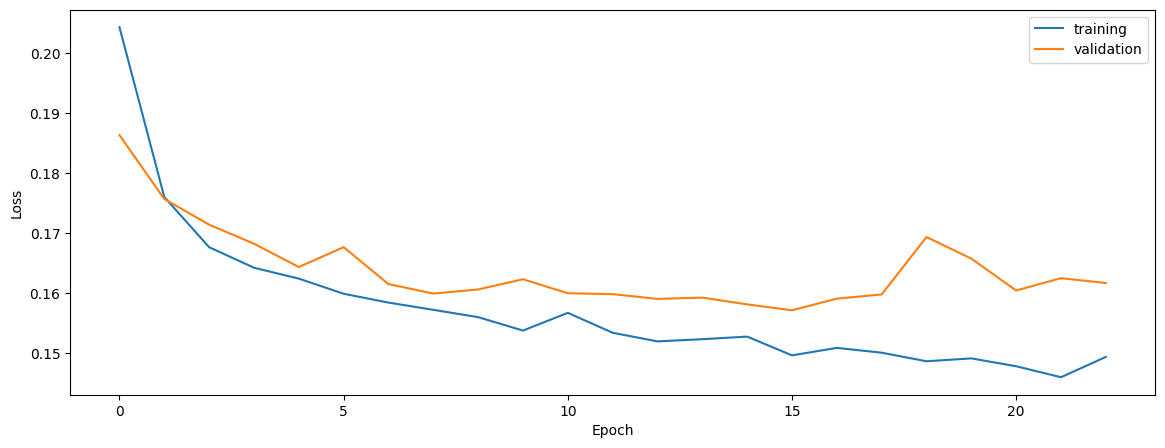

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6618879589989729
0.6325777420744415
0.6381318285508465


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6583471157219466
0.6429512516469038
0.6424954425764634


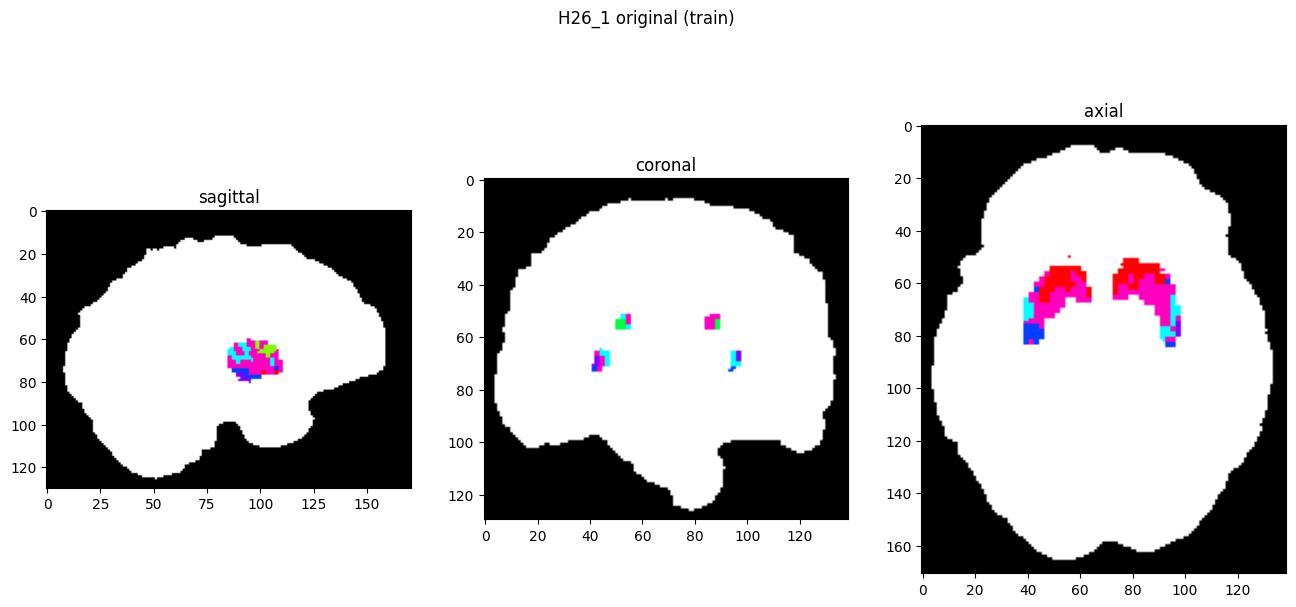

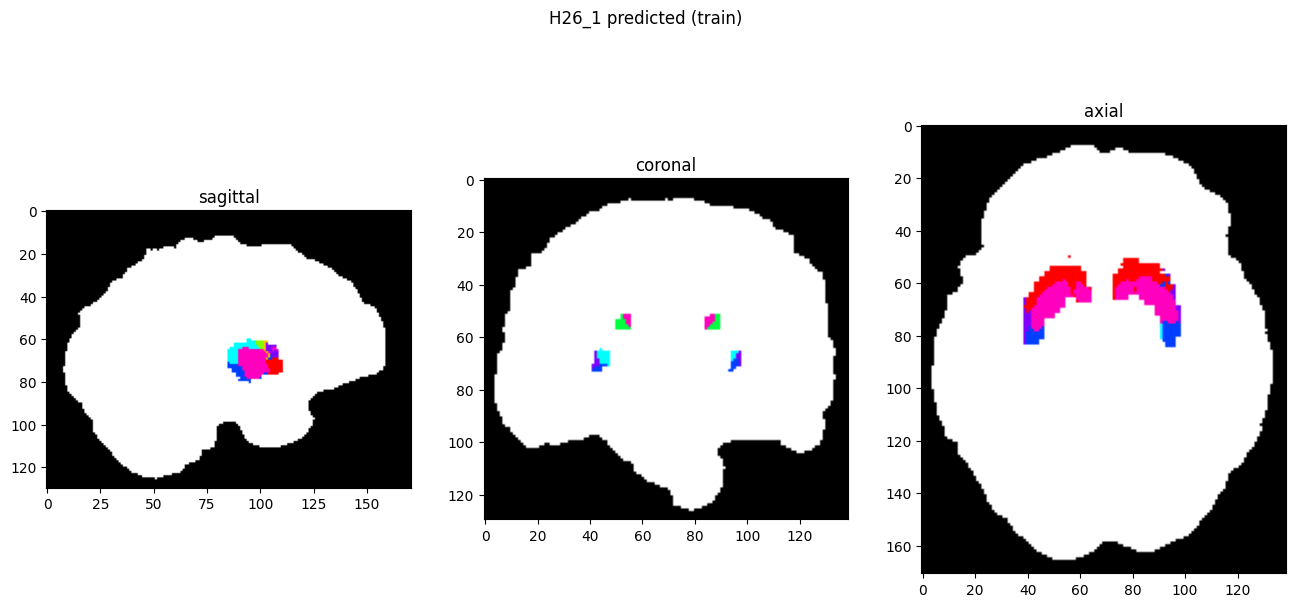

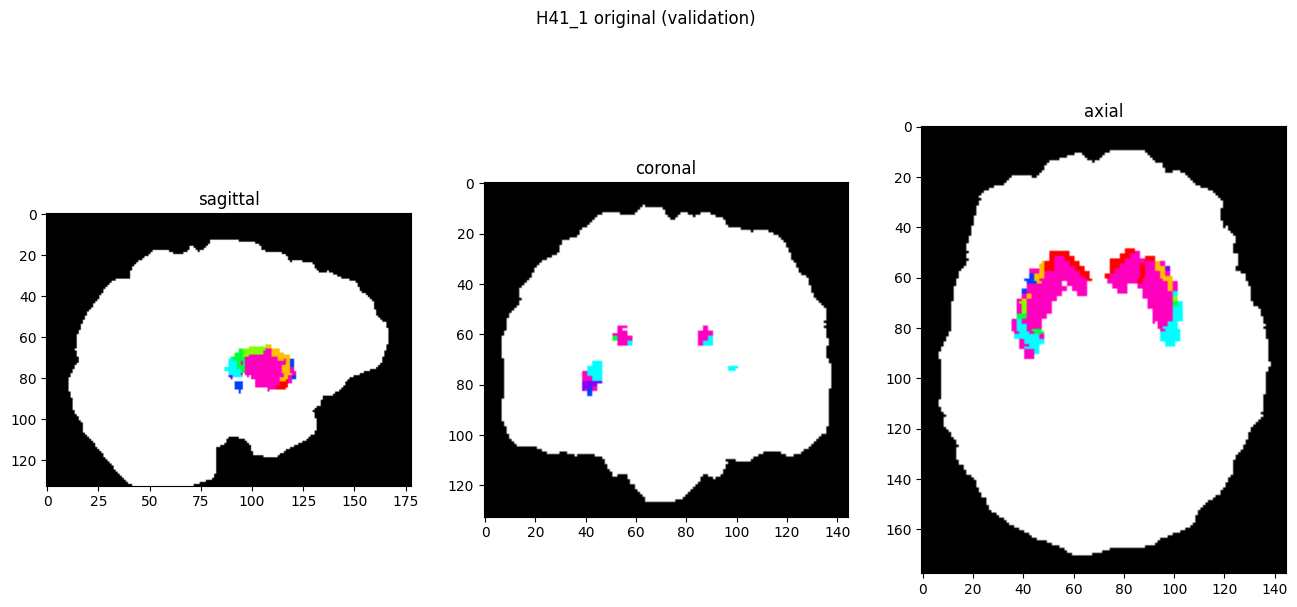

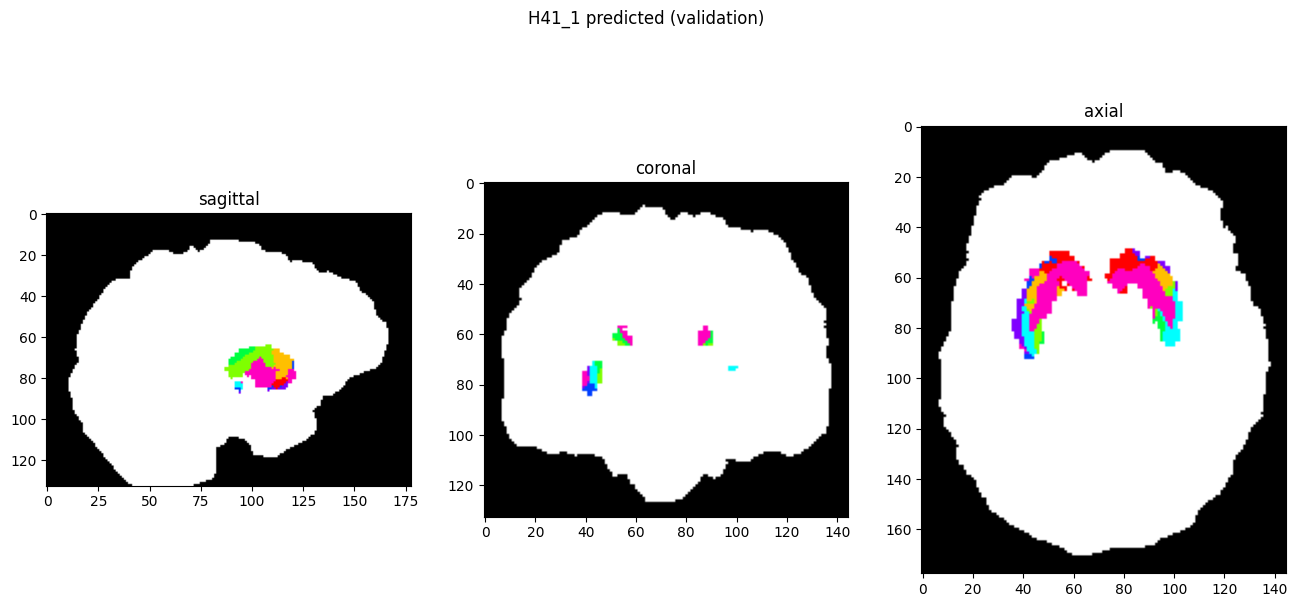

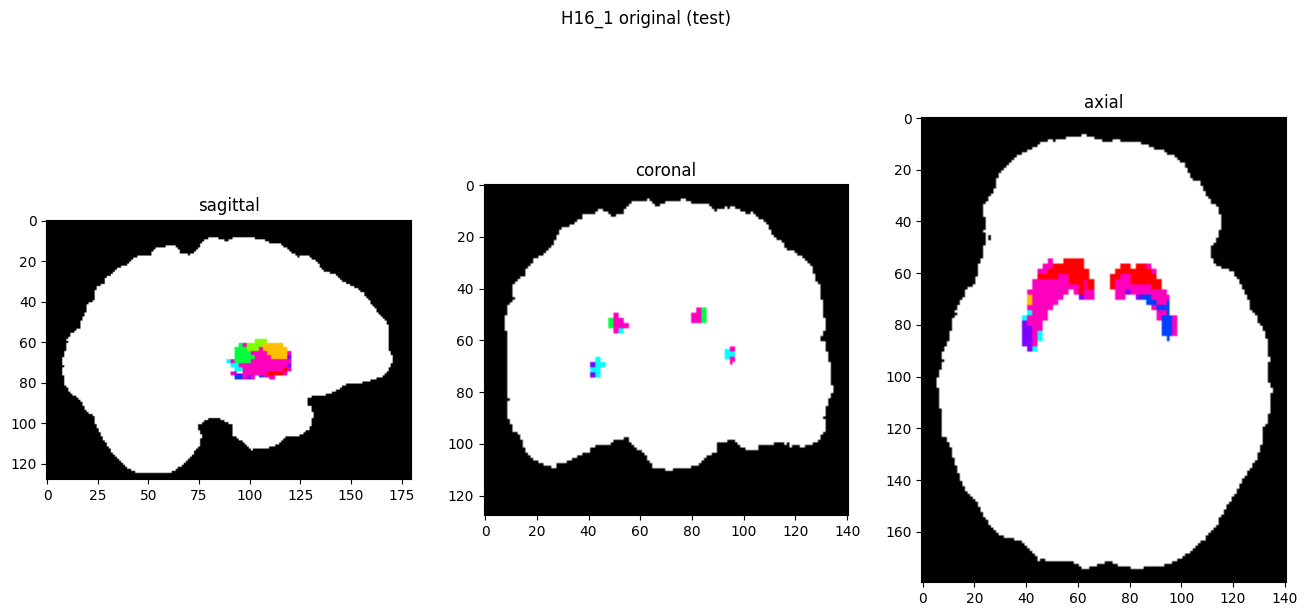

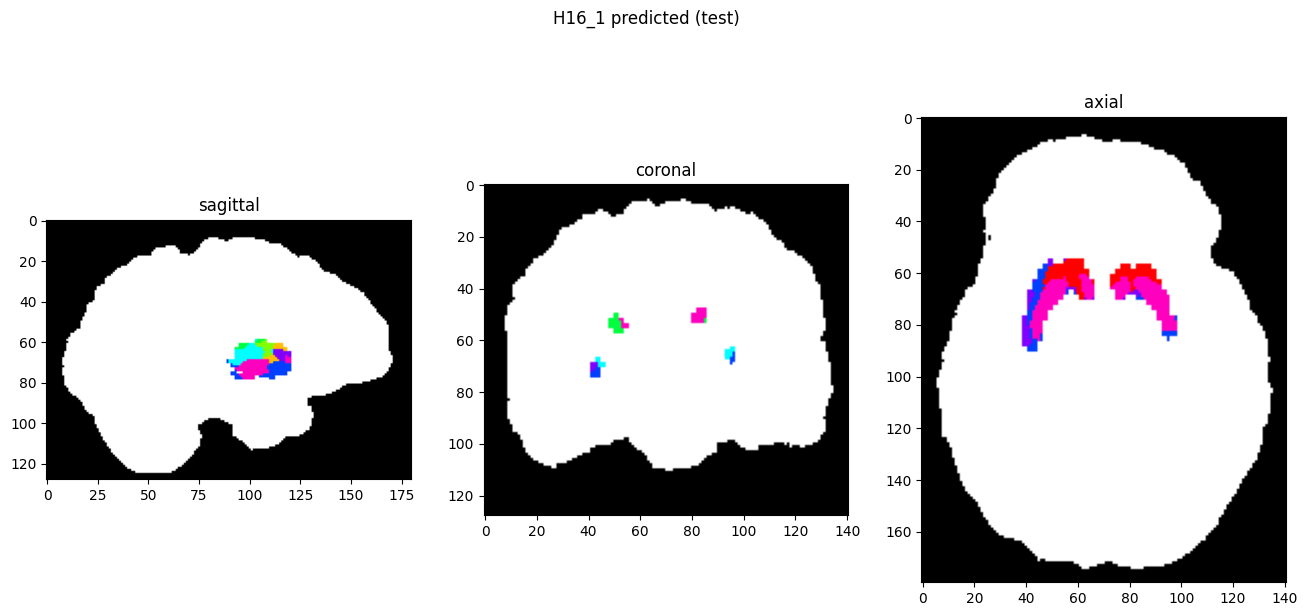

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)